In [37]:
import time
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains


In [41]:

all_milk_url = "https://www.shufersal.co.il/online/he/%D7%A7%D7%98%D7%92%D7%95%D7%A8%D7%99%D7%95%D7%AA/%D7%A1%D7%95%D7%A4%D7%A8%D7%9E%D7%A8%D7%A7%D7%98/%D7%97%D7%9C%D7%91-%D7%95%D7%91%D7%99%D7%A6%D7%99%D7%9D/c/A01"
milk_eggs_url = "https://www.shufersal.co.il/online/he/%D7%A7%D7%98%D7%92%D7%95%D7%A8%D7%99%D7%95%D7%AA/%D7%A1%D7%95%D7%A4%D7%A8%D7%9E%D7%A8%D7%A7%D7%98/%D7%97%D7%9C%D7%91-%D7%95%D7%91%D7%99%D7%A6%D7%99%D7%9D/%D7%9E%D7%95%D7%A6%D7%A8%D7%99-%D7%97%D7%9C%D7%91-%D7%95%D7%91%D7%99%D7%A6%D7%99%D7%9D/c/A0107"
pure_milk_url = "https://www.shufersal.co.il/online/he/%D7%A7%D7%98%D7%92%D7%95%D7%A8%D7%99%D7%95%D7%AA/%D7%A1%D7%95%D7%A4%D7%A8%D7%9E%D7%A8%D7%A7%D7%98/%D7%97%D7%9C%D7%91-%D7%95%D7%91%D7%99%D7%A6%D7%99%D7%9D/%D7%9E%D7%95%D7%A6%D7%A8%D7%99-%D7%97%D7%9C%D7%91-%D7%95%D7%91%D7%99%D7%A6%D7%99%D7%9D/%D7%97%D7%9C%D7%91-%D7%98%D7%A8%D7%99/c/A010701"
url = all_milk_url
# Define Browser Options
chrome_options = Options()
chrome_options.add_argument("no-sandbox")
#chrome_options.add_argument("--disable-gpu")
chrome_options.add_argument("--window-size=1920,2500")
chrome_options.add_argument("--headless") # Hides the browser window
# Reference the local Chromedriver instance
chrome_path = 'C:/Users/User/PycharmProjects/chromedriver.exe'
driver = webdriver.Chrome(executable_path=chrome_path, options=chrome_options)
# Run the Webdriver, save page an quit browser

In [42]:
%%time
driver.get(url)

def add_attribute_from_text(row, text, inverse=False):
    tokens = text.split('\n')
    if len(tokens) == 3:
        value, units,measurement = tokens
    elif len(tokens) == 2:
        value,measurement = tokens
    else:
        return

    if inverse:
        row[value] = measurement
    else:
        row[measurement] = value
def open_product(product):
    try:
        wait = WebDriverWait(driver,10)
        wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a[data-product-code='{}']".format(code))))
        actions = ActionChains(driver)
        actions.move_to_element(product).perform()
        product.click()
    except BaseException as err:
        print('problem with product click', row['name'], 'after', len(dataset), 'items')
        raise err
    
    for i in range(10):
        time.sleep(1)
        if driver.find_elements_by_class_name('productImgCarousel')[0].is_displayed():
            break
            
    legal = driver.find_element_by_class_name('legalNotes')
    try:
        actions = ActionChains(driver)
        actions.move_to_element(legal).perform()
    except BaseException:
        time.sleep(2)
        try:
            actions.move_to_element(legal).perform()
        except BaseException as err:
            print('problem with moving to legal', row['name'], 'after', len(dataset), 'items')
            raise err
            
def get_nutrition(row):
    nutrition = driver.find_elements_by_class_name('nutritionItem')
    if nutrition:                            
        prev_length = 0
        while prev_length != len(row):
            prev_length = len(row)
            for x in nutrition:
                add_attribute_from_text(row, x.text)
            next_buttons = driver.find_element_by_class_name('nutritionList').find_elements_by_css_selector('button[aria-label="לשקופית הקודמת"]')
            if next_buttons:
                try:
                    next_buttons[0].click()
                except BaseException as err:
                    time.sleep(2)
                    try:
                        next_buttons[0].click()
                    except BaseException as err:
                        print('problem with arrow click', row['name'], 'after', len(dataset), 'items')
                        raise err
                time.sleep(0.5)
            else:
                break
        if "קל" in row.keys() or "מג" in row.keys() or "גרם" in row.keys():
            print('Found error in nutrition scan', [x.text for x in nutrition])
            raise KeyError

def get_description(row):
    cnt = 0
    while 'מק"ט:' not in row.keys():
        
        product_infos = driver.find_elements_by_class_name('dataList')[0].find_elements_by_class_name('box')
        actions = ActionChains(driver)
        actions.move_to_element(driver.find_elements_by_class_name('dataList')[0]).perform()
        for x in product_infos:
            add_attribute_from_text(row, x.text, inverse=True) 
        cnt += 1
        if cnt == 10:
            print('Product info timeout', [x.text for x in product_infos])
            raise KeyError
            
def close_product():
    try:
        button = [x for x in driver.find_elements_by_class_name("modal-dialog") if x.get_attribute('data-gtm')][0].find_element_by_class_name('btnClose')
        actions = ActionChains(driver)
        actions.move_to_element(button).perform()
        time.sleep(0.5)
        button.click()
    except BaseException as err:
        print('problem with close click')
        raise err

Wall time: 6.62 s


In [43]:
%%time
clickable_products = [x for x in driver.find_elements_by_class_name('imgContainer') if x.get_attribute('aria-label')]
print(len(clickable_products))
used_codes = set()
problematic = set()
dataset = []
while True:
    for product in clickable_products:
        code = product.get_attribute('data-product-code')
        row = {"name": product.get_attribute('aria-label') }
        try:
            open_product(product)
            get_nutrition(row)
            get_description(row)
            close_product()
            dataset.append(row)
            used_codes.add(code)
        except BaseException as err:
            if code in problematic:
                print('recurring problem with item', product.get_attribute('aria-label'),err)
                used_codes.add(code)
            else:
                problematic.add(code)
                print('first time problem with item', product.get_attribute('aria-label'), err)
                if type(err) == KeyboardInterrupt:
                    raise err
            try:
                close_product()
            except BaseException as err2:
                continue
            
    clickable_products = driver.find_elements_by_class_name('imgContainer')#('miglog-sellingmethod-by_unit')
    clickable_products = [x for x in clickable_products if x.get_attribute('aria-label') and x.get_attribute('data-product-code') not in used_codes]
    if not len(clickable_products):
        break
    print('starting additional iteration for {} more samples'.format(len(clickable_products)))
    
len(dataset)

87
starting additional iteration for 32 more samples
starting additional iteration for 38 more samples
starting additional iteration for 48 more samples
starting additional iteration for 26 more samples
first time problem with item יוגורט עיזים עם דובדבן Message: stale element reference: element is not attached to the page document
  (Session info: headless chrome=94.0.4606.81)

starting additional iteration for 45 more samples
starting additional iteration for 38 more samples
starting additional iteration for 59 more samples
starting additional iteration for 25 more samples
starting additional iteration for 50 more samples
starting additional iteration for 44 more samples
first time problem with item שוקו בשקית יטבתה Message: stale element reference: element is not attached to the page document
  (Session info: headless chrome=94.0.4606.81)

starting additional iteration for 53 more samples
starting additional iteration for 24 more samples
starting additional iteration for 24 more sam

1405

In [44]:
len(dataset)

1405

In [30]:


product_infos = driver.find_elements_by_class_name('dataList')[0].find_elements_by_class_name('box')
for x in product_infos:
    add_attribute_from_text(row, x.text, inverse=True)

row

{'name': 'חלב מפוסטר 1% בקרטון',
 'אנרגיה': '86',
 'חלבונים': '6.7',
 'פחמימות': '10.2',
 'שומנים': '2',
 'כולסטרול': '6',
 'נתרן': '100',
 'סידן': '100',
 'חומצות שומן טרנס': 'פחות מ 0.5',
 'מתוכם שומן רווי': '0.6',
 'מותג/יצרן:': 'תנובה',
 'מידה/סוג:': '1 ליטר',
 'מק"ט:': '42435',
 'ארץ ייצור:': 'ישראל',
 'חלבי/בשרי/פרווה:': 'חלבי',
 'כשרות:': 'הרב ויטמן'}

In [48]:

clickable_products = [x for x in driver.find_elements_by_class_name('imgContainer') if x.get_attribute('aria-label')]

In [49]:
len(clickable_products)

1418

In [45]:
import pandas as pd
df = pd.DataFrame.from_dict(dataset)
df.describe()

,name,מותג/יצרן:,מידה/סוג:,"מק""ט:",ארץ ייצור:,כשרות:,סוכרים מתוך פחמימות,אנרגיה,חלבונים,פחמימות,...,חומצות שומן רווי,ניקוטינאמיד,סיבים בלתי מסיבים,מתוכם שומן בלתי רווי,C ויטמין,ויטמין A שווי רטינול,6 חומצות שומן אומגה,E ויטמין,שומן רב בלתי רווי,שומן חד בלתי רווי
count,1405,1405,1404,1405,1390,1118,743,1300,1201,1164,...,67,1,1,1,1,1,4,7,1,1
unique,1290,126,161,1405,23,30,148,369,173,205,...,30,1,1,1,1,1,2,1,1,1
top,ביצים L שופרסל,שופרסל,מחיר לפי משקל,474021,ישראל,הרב רובין,0,60,10,0,...,3,22,0,3,170,900,18.5,1.8,0,0
freq,6,118,218,1,1033,217,90,24,42,95,...,6,1,1,1,1,1,2,7,1,1


In [51]:
df.values[:, 3]

array(['7296073410447', '7296073410638', '7296073410553', ...,
       '5411188094159', '8000215202406', '8000215202413'], dtype=object)

In [52]:
[x for x in problematic if x[2:] not in df.values[:, 3]]

['P_7290110325312']

In [53]:
df.to_csv('./milk_data_1405.csv')

In [136]:
df.columns
df[['name','מק"ט', 'אנרגיה', 'חלבונים', 'פחמימות', 'שומנים','נתרן']]
df

,name,סוכרים מתוך פחמימות,אנרגיה,חלבונים,פחמימות,שומנים,כולסטרול,מותג/יצרן,מידה/סוג,"מק""ט",...,רבנות מקומית,חלבי/בשרי/פרווה,כשרות,נתרן,סיבים תזונתיים,D ויטמין,כשרות פסח,סידן,אבקת חלב נוכרי,פסח
0,חלב אורגני גרין 1% שומן,5,43,3.4,5,1,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,חלב אורגני גרין 3% שומן,5,60,3.3,5,3,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,חלב 3% בקרטון שופרסל,5,60,3.3,5,3,9,שופרסל,1 ליטר,7296073231554,...,רמת הגולן,חלבי,הרב אוירבך,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,חלב 1% בקרטון שופרסל,NaN,43,3.4,5.1,1,3,שופרסל,1 ליטר,7296073231547,...,NaN,חלבי,הרב אוירבך,40,NaN,NaN,NaN,NaN,NaN,NaN
4,משקה חלב מועשר 3% שומן,5,62,3.3,5,NaN,NaN,שופרסל,1 ליטר,7296073232445,...,רמת הגולן,חלבי,הרב אוירבך,NaN,1,1,NaN,NaN,NaN,NaN
5,חלב נטול לקטוז 3% גרין,5,60,3.3,5,3,9,שופרסל גרין,1 ליטר,7296073265344,...,טבריה,NaN,רבנות מקומית,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,חלב נטול לקטוז 1% גרין,5.1,43,3.4,5.1,1,NaN,שופרסל גרין,1 ליטר,7296073232377,...,NaN,NaN,רבנות מקומית,NaN,1,NaN,NaN,NaN,NaN,NaN
7,חלב נטול לקטוז2% שומן,5,51,3.3,5,2,NaN,שופרסל גרין,1 ליטר,7296073399544,...,NaN,NaN,NaN,40,NaN,NaN,NaN,NaN,NaN,NaN
8,חלב בקרטון 3% שומן,NaN,60,3.3,4.95,3,9,תנובה,1 ליטר,4131074,...,NaN,NaN,ועדת מהדרין תנובה,50,NaN,NaN,ועדת מהדרין תנובה,NaN,NaN,NaN
9,חלב מפוסטר 3% בקרטון,NaN,120,6.6,9.9,6,18,תנובה,1 ליטר,42442,...,NaN,חלבי,הרב ויטמן,100,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.

In [162]:

nutrition = driver.find_elements_by_class_name('nutritionItem')
for x in nutrition:
    print(x.text)

5
גרם
סוכרים מתוך פחמימות
43
קל
אנרגיה
3.4
גרם
חלבונים
5
גרם
פחמימות
1
גרם
שומנים
3
מג
כולסטרול
40
מג
נתרן
0.6
גרם
מתוכם שומן רווי
פחות מ 0.5
גרם
חומצות שומן טרנס
110
מג
סידן


In [127]:
driver.find_elements_by_class_name('dataList')[0].text.split('\n')[0][:-1]

'מותג/יצרן'

In [155]:
driver.find_elements_by_class_name('nutritionItem')[1].text

'43\nקל\nאנרגיה'

In [133]:
a[0].click()
driver.wait(10)
b = driver.find_elements_by_class_name('nutritionItem')
for x in b:
    print(x.text)
b = driver.find_elements_by_class_name('dataList')
for x in b:
    print(x.text)

ElementClickInterceptedException: Message: element click intercepted: Element <a href="javascript:void(0)" role="button" class="imgContainer" aria-label="חלב אורגני גרין 1% שומן" data-target="#productModal" data-product-code="P_7296073426530" draggable="false">...</a> is not clickable at point (710, 490). Other element would receive the click: <div class="smallText">...</div>
  (Session info: headless chrome=94.0.4606.71)


In [110]:
c = [x for x in driver.find_elements_by_class_name('btnClose') if x.get_attribute('data-dismiss') == 'modal']
for x in c:
    try:
        x.find_elements_by_class_name("icon-PH-16PX")
        print('1')
    except:
        continue

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [115]:
[x for x in driver.find_elements_by_class_name("modal-dialog") if x.get_attribute('data-gtm')][0].find_element_by_class_name('btnClose').click()

In [117]:
a[1].click()

In [ ]:
def open_browser():
    driver = webdriver.Chrome("../chromedriver.exe")
    driver.get(url)
    driver.find_element_by_id('bt_gerar_cpf').click()
    text_field = driver.find_element_by_id('texto_cpf')
    text = wait(driver, 10).until(lambda driver: not text_field.text == 'Gerando...' and text_field.text)
    return text

print(open_browser())

In [17]:

df.trail = df.trail.map(lambda x: x[::-1].strip() if x != -1 else 'unknown')
df.faculty = df.faculty.map(lambda x: x[::-1].strip())
df.degree = df.degree.map(lambda x: x[::-1].strip())

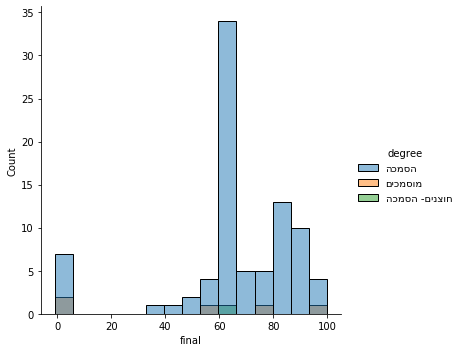

In [18]:
import seaborn as sns
sns.displot(x='final', hue='degree', data=df,bins=15)

In [19]:
q = list(df.trail.unique()[1:3]) + [df.trail.unique()[0]]
q
#q = q[1:] + q[:1]

['עדימו םינותנ', 'עדימ תוכרעמ', 'לוהינו הישעת']

In [20]:
df = df[df.degree == 'הסמכה'[::-1]]
df = df[df.trail.map(lambda x: x in q)]
df.head()

,id,name,g,faculty,degree,trail,email,final
0,207721218,אבו סלאח יארא,11,לוהינו הישעת,הכמסה,לוהינו הישעת,yaraabusalah@campus.technion.ac.il,58.0
1,322386202,אברהם אופק,11,לוהינו הישעת,הכמסה,עדימו םינותנ,ofekavraham@campus.technion.ac.il,90.0
2,203371737,אהרון עדי,12,לוהינו הישעת,הכמסה,לוהינו הישעת,ah@campus.technion.ac.il,64.0
3,212238091,אוחטרוב מיכאל,12,לוהינו הישעת,הכמסה,עדימו םינותנ,michael.ukh@campus.technion.ac.il,80.0
4,311287791,אולשביצקי עופרי,12,לוהינו הישעת,הכמסה,עדימו םינותנ,ofriol@campus.technion.ac.il,-1.0


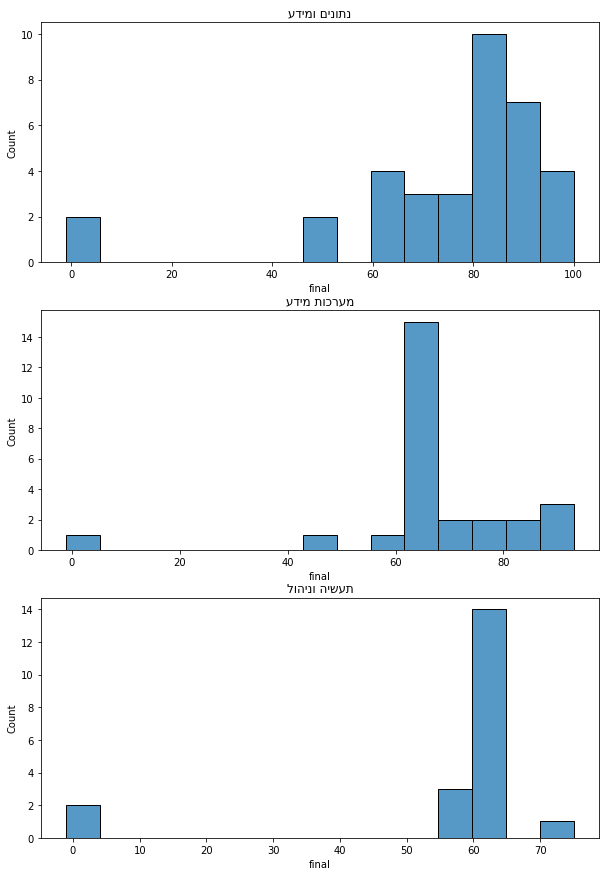

In [28]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(3,1, figsize=(10,15))
for i in range(3):
    #f = plt.figure()
    p = sns.histplot(x='final', data=df[(df.trail == q[i])], bins=15, ax=ax[i])
    p.set_title(q[i])

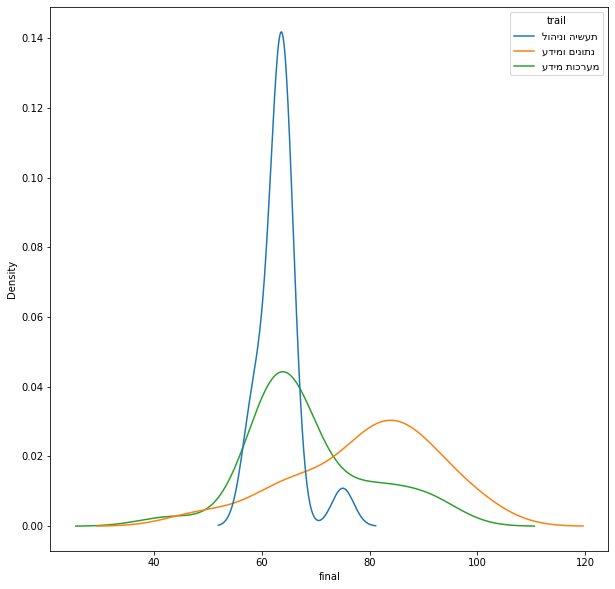

In [29]:
f = plt.figure(figsize=(10,10))
p = sns.kdeplot(x='final', hue='trail',data=df[df.final > 0], common_norm=False)

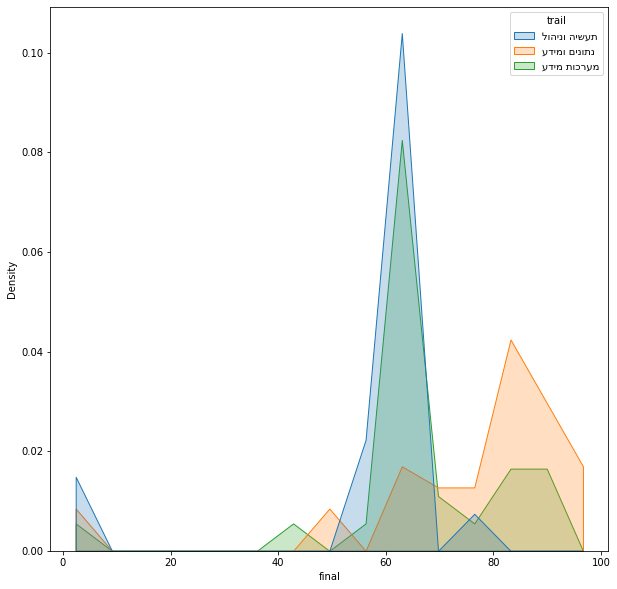

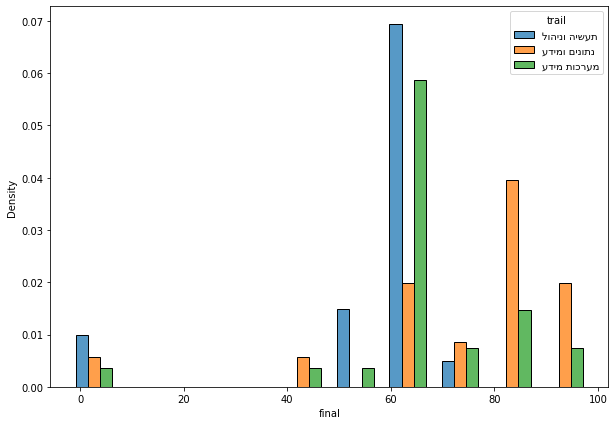

In [31]:
f = plt.figure(figsize=(10,10))
p = sns.histplot(x='final', hue='trail', bins=15, data=df, element="poly", stat='density', common_norm=False)
f = plt.figure(figsize=(10, 7))
p = sns.histplot(x='final', hue='trail', bins=10, data=df, stat='density', common_norm=False, multiple="dodge" , shrink=.7)

In [29]:
data = """0 1 1 1 0
0 0 1 1 0
0 0 1 1 0
1 1 1 1 1
1 0 1 1 1
1 0 1 1 1
1 1 0 0 0
1 0 0 0 0
0 0 0 0 0
1 1 1 1 1
1 0 0 1 0
1 0 1 0 0
1 1 0 1 1
1 1 0 0 1
0 1 0 0 0
1 0 0 0 0
0 0 0 0 0
0 0 1 0 0
1 0 1 0 1
0 0 1 0 1
1 1 0 1 1
0 1 1 0 1"""
data = [z.split(' ') for z in data.split('\n')]
data = np.array(data, dtype=int)

In [34]:
data[:, 1].sum()

9

In [33]:
idx = data[:, 1] == 0
data[idx, ]
data.shape

(22, 5)

In [36]:
import pandas as pd
df = pd.DataFrame(columns=['Z','X','T','Y','W'], data=data)

In [41]:
df.groupby(['X', 'Y']).mean()

Z     T     W
X Y                 
0 0  0.5  0.50  0.25
  1  0.6  0.80  0.40
1 0  0.5  0.25  0.50
  1  0.8  0.60  0.80